**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing Skin Cancer Data - Data import and visualization**

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
#Count the number of images in the train and test folder

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
# # #Delete augmented 'output' folder from previous run, run this cell only if you have run the Augmentor pipeline to generate augmented data
# import shutil

# for i in os.listdir(str(data_dir_train)):
#   path = str(data_dir_train) + '/' + i + '/' + 'output'
#   if os.path.exists(path) and os.path.isdir(path):
#     shutil.rmtree(path)

In [ ]:
#Check the number of Images per class

for i in os.listdir(str(data_dir_train)):
  path = str(data_dir_train) + '/' + i
  print(i , ':' , len(list(pathlib.Path(path).glob('*.jpg'))))

  #Looks like we have very less number of data points per class

actinic keratosis : 114
nevus : 357
pigmented benign keratosis : 462
seborrheic keratosis : 77
vascular lesion : 139
dermatofibroma : 95
basal cell carcinoma : 376
melanoma : 438
squamous cell carcinoma : 181


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
#Define important parameters

batch_size = 32
img_height = 180
img_width = 180
input_shape = (180,180,3)

Use 80% of the images for training, and 20% for validation.

In [ ]:
from keras.utils import image_dataset_from_directory
#convert image folders to train dataset

train_ds = image_dataset_from_directory(data_dir_train,seed=123,image_size=(180,180),color_mode='rgb',batch_size=batch_size,subset='training', validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#convert image folders to test dataset
val_ds = image_dataset_from_directory(data_dir_train,seed=123,image_size=(180,180),color_mode='rgb',batch_size=batch_size,subset='validation', validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

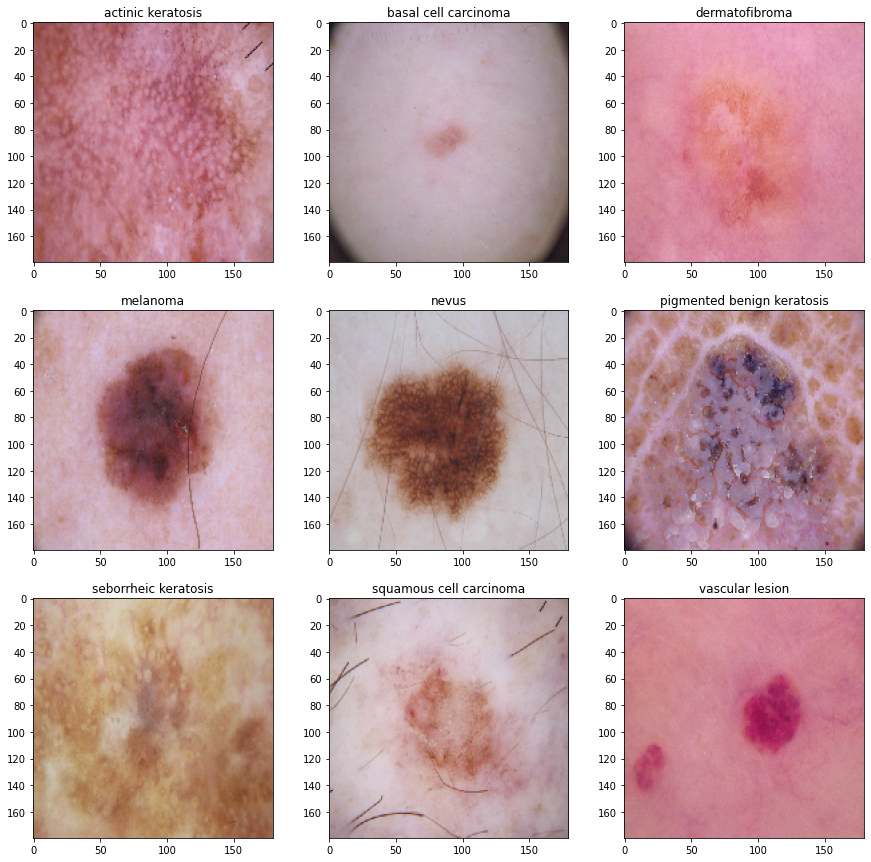

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#Function to plot the accuracy and loss 

def plot_accuracy_loss(hist, epochs):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
#Rescale Layer
input_shape = [img_height,img_width,3]
rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range  
  layers.experimental.preprocessing.Rescaling(1./255,input_shape = input_shape)
])

In [ ]:
#Model_1 with only conv,pooling layers,one flatten layer and a couple of FC layers

num_classes = 9

# a keras convolutional layer is called Conv2D

# building a linear stack of layers with the sequential model
model_1 = Sequential()

#Add rescaling layer at the start
model_1.add(rescale)

# convolutional layer 1

model_1.add(Conv2D(64, kernel_size=(3,3), padding = 'same', strides=(1,1), activation='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))


# convolutional layer 2
model_1.add(Conv2D(128, kernel_size=(3,3),padding = 'same',activation='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))


# flatten output of conv
model_1.add(Flatten())


# hidden layer (Fully connected)
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))

# output layer
model_1.add(Dense(num_classes, activation='softmax'))


In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)           

### Compile the model
Choose an appropirate optimiser and loss function for model training 

### Train the model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#Choosing sparse categorical crossentropy as loss function
#Choosing adam as optimizer --> Default Learning rate 0.001
#Model_1 --> 2 conv layers, 1 flatten layer, 2 Dense FC layers, 1 output layer

model_1.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam())

In [ ]:
#Fit the model

epochs = 20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 313s 1s/step - loss: 3.0460 - accuracy: 0.2059 - val_loss: 2.0148 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 4s 71ms/step - loss: 1.7940 - accuracy: 0.3482 - val_loss: 1.6087 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5783 - accuracy: 0.4442 - val_loss: 1.5121 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4293 - accuracy: 0.4911 - val_loss: 1.4587 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.3542 - accuracy: 0.5246 - val_loss: 1.4452 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 1.1913 - accuracy: 0.5675 - val_loss: 1.4733 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 4s 70ms/step - loss: 1.1058 - accuracy: 0.6077 - val_loss: 1.4270 - val_accuracy: 0.5347
Epoch 8/20
56

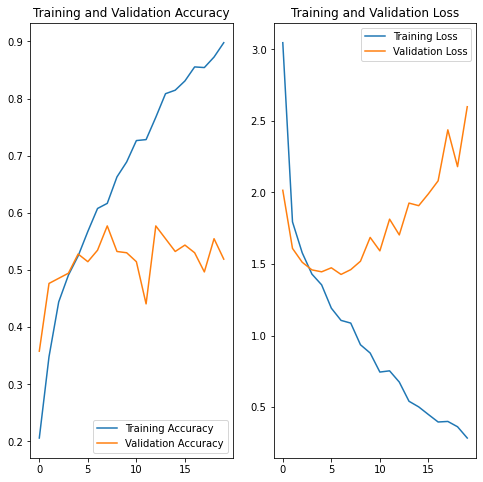

In [ ]:
#Plot results

plot_accuracy_loss(history_1,epochs)

**Observation:** We can see that in this model the training accuracy is 89.79% and validation accuracy is 51.9% which indicates that the model is overfitting. Let's try to add some overfitting control measures i.e. Data Augmentation, dropouts, batch normalization etc. and observe the performance. 

##**Data Augmentation, Dropouts and Batch Normalization**

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Define the data augmentation layer

data_augmentation = tf.keras.Sequential([
    
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    #layers.RandomContrast(0.5),
    #layers.RandomTranslation(0.2,0.2)
  ]
)

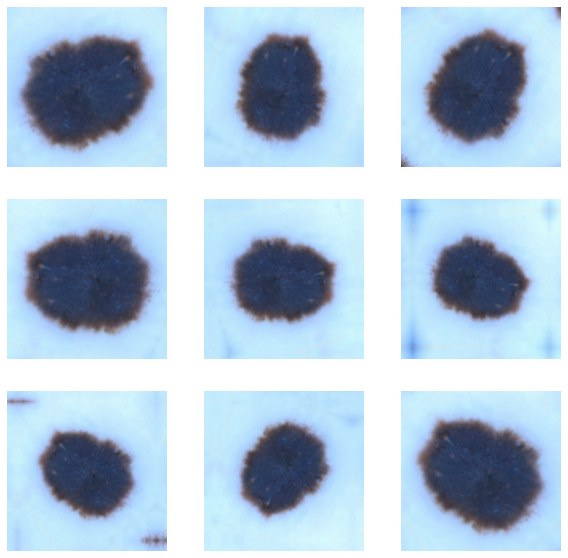

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Visualize one of the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images,training = True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
### Your code goes here
input_shape = [img_height,img_width,3]

num_classes = 9

# a keras convolutional layer is called Conv2D

# building a linear stack of layers with the sequential model
model_2 = Sequential()

#Add Data augmentation layers
model_2.add(data_augmentation)

#Add rescaling layer at the start
model_2.add(rescale)

# convolutional layer 1

model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=(3,3), padding = 'same', strides=(1,1), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))


# convolutional layer 2
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, kernel_size=(3,3),padding = 'same',activation='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))


# flatten output of conv
model_2.add(Flatten())


# hidden layer (Fully connected)
model_2.add(BatchNormalization())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(BatchNormalization())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))

# output layer
model_2.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [ ]:
## Compile the model

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs =20
history_2 = model_2.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 7s 83ms/step - loss: 1.9829 - accuracy: 0.3270 - val_loss: 2.3052 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6724 - accuracy: 0.4113 - val_loss: 2.6760 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5604 - accuracy: 0.4554 - val_loss: 2.8247 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4801 - accuracy: 0.4749 - val_loss: 2.7918 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 73ms/step - loss: 1.4462 - accuracy: 0.4860 - val_loss: 2.4268 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.3759 - accuracy: 0.5117 - val_loss: 1.9656 - val_accuracy: 0.3244
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.3717 - accuracy: 0.5123 - val_loss: 1.5388 - val_accuracy: 0.4295
Epoch 8/20
56

### Visualizing the results

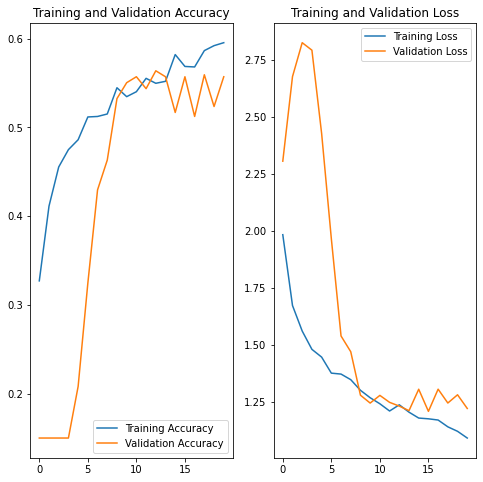

In [ ]:
#Plot results
plot_accuracy_loss(history_2,epochs)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation:** Adding the data augmentation layer, dropouts and batch normalization helped to control overfitting but now the training accuracy has also come down to 59.5% and the validation accuracy is 55.7% which means the model is now underfitting. Let's try to analyze if there is some class imbalance in the given data set. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#Images per class

image_dict = {}
imgclass = []
count = []
for i in os.listdir(str(data_dir_train)):
  path = str(data_dir_train) + '/' + i
  # print(i , ':' , len(list(pathlib.Path(path).glob('*.jpg'))))
  imgclass.append(i)
  count.append(len(list(pathlib.Path(path).glob('*.jpg'))))

image_dict = {'Class':imgclass,'Count':count}

img_dict = pd.DataFrame(image_dict)
img_dict

,Class,Count
0,actinic keratosis,114
1,nevus,357
2,pigmented benign keratosis,462
3,seborrheic keratosis,77
4,vascular lesion,139
5,dermatofibroma,95
6,basal cell carcinoma,376
7,melanoma,438
8,squamous cell carcinoma,181


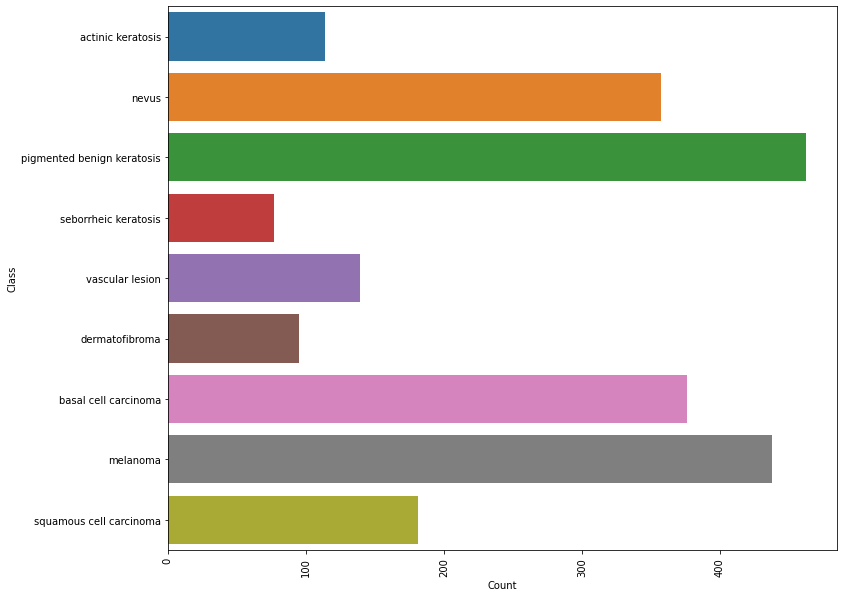

In [ ]:
import seaborn as sns

plt.figure(figsize = (12,10))
sns.barplot(y = img_dict.Class, x = img_dict.Count )
plt.xticks(rotation = 90)
plt.show()

#### **Todo:** Write your findings here: 
#### - **Which class has the least number of samples?** --> **seborrheic keratosishas** least number of samples (77)
#### - **Which classes dominate the data in terms proportionate number of samples?** --> **pigmented benign keratosis** (462) has the maximum number of images.

It seems like the class imbalance issue for this dataset needs to be improved for getting some significant improvement in the model performance. 


In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(lesion_list)

2239

In [ ]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#Let's generate 800 images per class using the Augmentor package to resolve the class imbalance issue in the dataset. 

path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/'+i)
    p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
    p.sample(800) ## We are adding 800 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF46004D350>: 100%|██████████| 800/800 [00:35<00:00, 22.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3EE721310>: 100%|██████████| 800/800 [00:33<00:00, 23.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF3EE687790>: 100%|██████████| 800/800 [00:34<00:00, 23.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF460051BD0>: 100%|██████████| 800/800 [02:33<00:00,  5.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2314x2067 at 0x7FF460051B50>: 100%|██████████| 800/800 [02:21<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF460620E90>: 100%|██████████| 800/800 [00:31<00:00, 25.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF46056FFD0>: 100%|██████████| 800/800 [01:13<00:00, 10.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF3EE254450>: 100%|██████████| 800/800 [00:31<00:00, 25.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF46B121950>: 100%|██████████| 800/800 [00:31<00:00, 25.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7200


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

7200

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

7200

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1262
melanoma                      1238
basal cell carcinoma          1176
nevus                         1157
squamous cell carcinoma        981
vascular lesion                939
actinic keratosis              914
dermatofibroma                 895
seborrheic keratosis           877
Name: Label, dtype: int64

So, now we have added 800 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9439 files belonging to 9 classes.
Using 7552 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #data_dir_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9439 files belonging to 9 classes.
Using 1887 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
### Your code goes here
input_shape = [img_height,img_width,3]

num_classes = 9

# a keras convolutional layer is called Conv2D

# building a linear stack of layers with the sequential model
model_3 = Sequential()

#Add Data augmentation layers
#model_3.add(data_augmentation)

#Add rescaling layer at the start
model_3.add(rescale)

# convolutional layer 1

model_3.add(BatchNormalization())
model_3.add(Conv2D(128, kernel_size=(3,3), padding = 'same', strides=(1,1), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))


# convolutional layer 2
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, kernel_size=(3,3),padding = 'same',activation='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))

# convolutional layer 3
model_3.add(BatchNormalization())
model_3.add(Conv2D(512, kernel_size=(3,3),padding = 'same',activation='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

# flatten output of conv
model_3.add(Flatten())


# hidden layer (Fully connected)
model_3.add(BatchNormalization())
model_3.add(Dense(128, activation='relu'))

model_3.add(BatchNormalization())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.4))

# output layer
model_3.add(Dense(num_classes, activation='softmax'))
model_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 batch_normalization_47 (Bat  (None, 180, 180, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 90, 90, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 90, 90, 128)      512       
 chNormalization)                                                
                                                     

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

#### **Todo:**  Train your model

In [ ]:
epochs = 20
## Your code goes here, use 30 epochs.
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
236/236 [==============================] - 77s 251ms/step - loss: 1.7226 - accuracy: 0.3672 - val_loss: 2.5652 - val_accuracy: 0.1547
Epoch 2/20
236/236 [==============================] - 59s 247ms/step - loss: 1.3538 - accuracy: 0.4934 - val_loss: 1.1766 - val_accuracy: 0.5670
Epoch 3/20
236/236 [==============================] - 60s 248ms/step - loss: 1.1687 - accuracy: 0.5677 - val_loss: 1.0425 - val_accuracy: 0.6084
Epoch 4/20
236/236 [==============================] - 61s 252ms/step - loss: 1.0033 - accuracy: 0.6280 - val_loss: 0.8562 - val_accuracy: 0.6842
Epoch 5/20
236/236 [==============================] - 61s 250ms/step - loss: 0.8871 - accuracy: 0.6725 - val_loss: 0.8679 - val_accuracy: 0.6910
Epoch 6/20
236/236 [==============================] - 60s 249ms/step - loss: 0.7870 - accuracy: 0.7062 - val_loss: 0.7813 - val_accuracy: 0.7064
Epoch 7/20
236/236 [==============================] - 59s 248ms/step - loss: 0.6684 - accuracy: 0.7456 - val_loss: 0.6584 - val_ac

#### **Todo:**  Visualize the model results

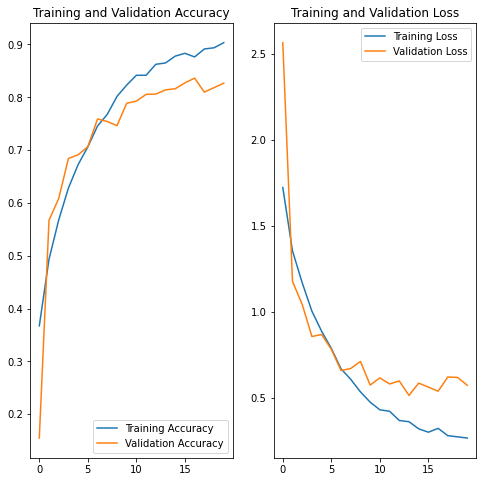

In [ ]:
#Plot results
plot_accuracy_loss(history_3,epochs)

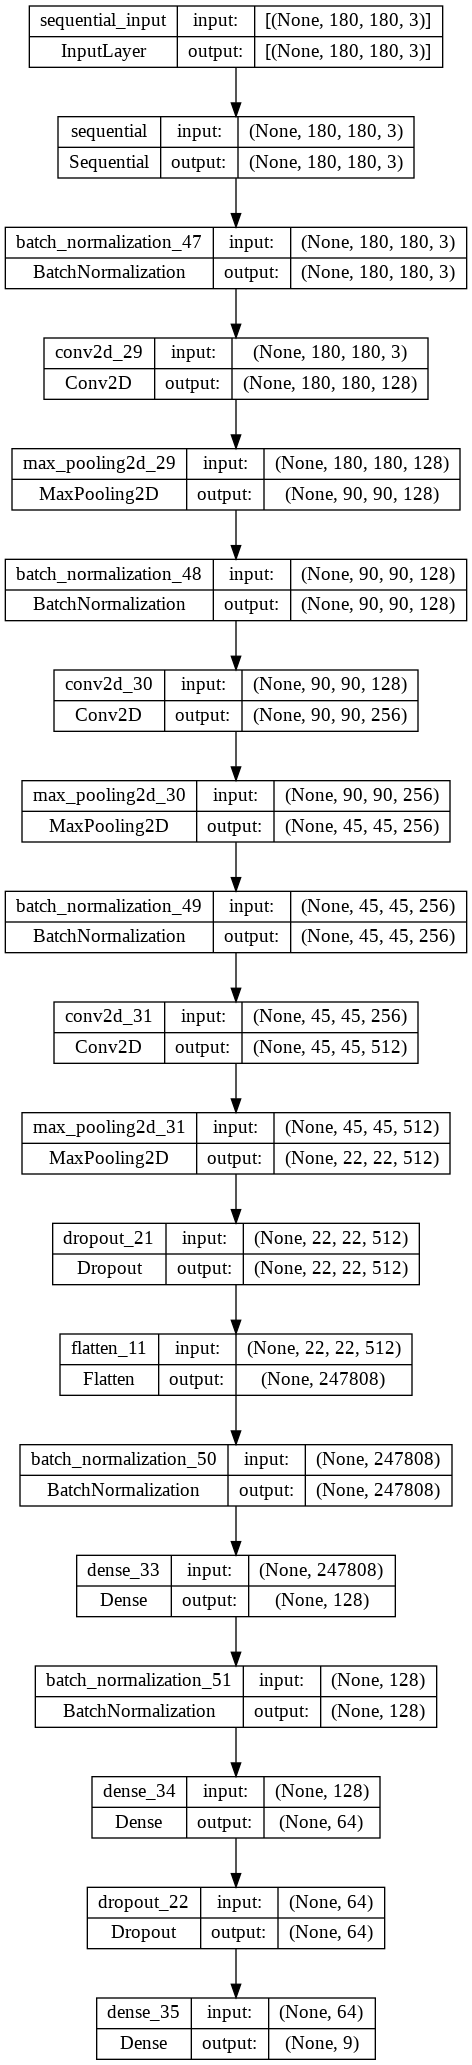

In [ ]:
#Visualize the model 

from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Final Observation:**

* After applying the Augmentor pipeline to fix the class imbalance issue, we could 
see the the issue of overfitting and underfitting is resolved. 
* We have a training accuracy of 90.3 and validation accuracy of 82.6 %, even the training and validation loss are very close after 20 epochs. So we can consider this as our final model. 